# Causal thinking  ...
Ruiji

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

## Data Preparation

### Import ASHRAE Thermal Comfort Database 2

In [3]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)

# Merge building metadata and measurement data
df_rawdata = df_measurements.merge(df_meta[['building_id', 'city', 'building_type', 'cooling_type', 'records', 'database']], on='building_id', how='left')

print('Total buildings:', len(df_rawdata.building_id.unique()))
print('Total records:', len(df_rawdata))

Total buildings: 809
Total records: 109033


/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_69716/1041017263.py:7: DtypeWarning: Columns (5,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_measurements = pd.read_csv(url_measurements)


In [4]:
#check df_meta for building id=735
# display all columns
pd.set_option('display.max_columns', None)
df_meta[df_meta.building_id==735]

,building_id,building_id_inf,contributor,publication,region,country,city,lat,lon,climate,building_type,cooling_type,year,records,has_age,has_ec,has_timestamp,timezone,met_source,isd_station,isd_distance,database,quality_assurance
734,735,yes,Siti Aisyah Damiati,https://doi.org/10.1016/j.buildenv.2016.09.024,asia,malaysia,kuala lumpur,3.139003,101.686855,tropical,office,air conditioned,2015,629,yes,no,yes,Asia/Kuala_Lumpur,NaN,486470-99999,15.3,2.1,pass


### Clean outdoor air temperature data

In [5]:
# Merge two outdoor air temperature columns as a new column
df_rawdata.loc[:, 't_out_combined'] = df_rawdata.loc[:, 't_out_isd'].fillna(df_rawdata.loc[:, 't_out'])

# Remove the two outdoor air temperature columns
df_rawdata = df_rawdata.drop(columns=['t_out_isd', 't_out'])

### Filter out buildings that have required data

In [6]:
# Keep rows that simultaneously have data for all variables in cols 
def filter(df, cols):
    df_qualifed = df.dropna(subset=cols)
    print(f'Qualified buildings:', len(df_qualifed['building_id'].unique()))
    print(f'Qualified records:', len(df_qualifed))
    return df_qualifed

# Keep rows that simultaneously have data for all variables in cols
cols_1 = ['t_out_combined', 'set', 'top', 'thermal_sensation']
df_data = filter(df_rawdata, cols_1).copy()

Qualified buildings: 518
Qualified records: 26307


In [9]:
# select only winter in the season column
df_data = df_data[df_data['season'] == 'winter']
# merge df_data with df_meta to get the country column
df_data = df_data.merge(df_meta[['building_id', 'country']], on='building_id', how='left')
# print city and corresponding country columns
print(df_data[['city', 'country']].drop_duplicates())

               city    country
0            sydney  australia
217    grand rapids        usa
324          auburn        usa
452       san ramon        usa
736         antioch        usa
847     south wales         uk
883      kalgoorlie  australia
1494       montreal     canada
1911        karachi   pakistan
2219       peshawar   pakistan
2455        quettar   pakistan
2705          saidu   pakistan
2830      ahmedabad      india
3022          delhi      india
3118        kolkata      india
3137         shimla      india
3295  san francisco        usa
4594     merseyside         uk
4893         el kef    tunisia
4894          gabes    tunisia
4896          gafsa    tunisia
5019           sfax    tunisia
5189          tunis    tunisia
5949       goulburn  australia
5995     wollongong  australia
6096      hampshire         uk


In [11]:
df_data.columns

Index(['index', 'record_id', 'building_id', 'timestamp', 'season',
       'subject_id', 'age', 'gender', 'ht', 'wt', 'ta', 'ta_h', 'ta_m', 'ta_l',
       'top', 'tr', 'tg', 'tg_h', 'tg_m', 'tg_l', 'rh', 'vel', 'vel_h',
       'vel_m', 'vel_l', 'met', 'clo', 'activity_10', 'activity_20',
       'activity_30', 'activity_60', 'thermal_sensation',
       'thermal_acceptability', 'thermal_preference', 'thermal_comfort',
       'air_movement_acceptability', 'air_movement_preference',
       'blind_curtain', 'fan', 'window', 'door', 'heater', 'rh_out',
       't_out_monthly', 'rh_out_isd', 'set', 'pmv', 'ppd', 'pmv_ce', 'ppd_ce',
       't_mot_isd', 'city', 'building_type', 'cooling_type', 'records',
       'database', 't_out_combined', 'country'],
      dtype='object')

In [12]:
# export ahmedabad data to csv
df_data[df_data['city'] == 'ahmedabad'].to_csv('db2_ahmedabad.csv', index=False)
# export kolkata data to csv
df_data[df_data['city'] == 'kolkata'].to_csv('db2_kolkata.csv', index=False)
# export delhi data to csv
df_data[df_data['city'] == 'delhi'].to_csv('db2_delhi.csv', index=False)



## Analysis on Single Building

In [7]:
# select one building and print out basic information
df_data_1bldg = df_data[df_data['building_id'] == 735]

print('field study period:', df_data_1bldg['timestamp'].min(), df_data_1bldg['timestamp'].max())
print('field study location:', df_data_1bldg.city.unique())
print('building type:', df_data_1bldg.building_type.unique())
print('cooling type:', df_data_1bldg.cooling_type.unique())
print('building occupants:', len(df_data_1bldg.subject_id.unique()))


field study period: 2015-04-13T00:00:00Z 2015-05-05T00:00:00Z
field study location: ['kuala lumpur']
building type: ['office']
cooling type: ['air conditioned']
building occupants: 1


### Approach (a)

/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_38203/88572578.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg['timestamp'] = pd.to_datetime(df_data_1bldg['timestamp'])
/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_38203/88572578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg[ 'days_since_start'] = (df_data_1bldg['timestamp'] - df_data_1bldg['timestamp'].min()).dt.days
/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_38203/88572578.py:20

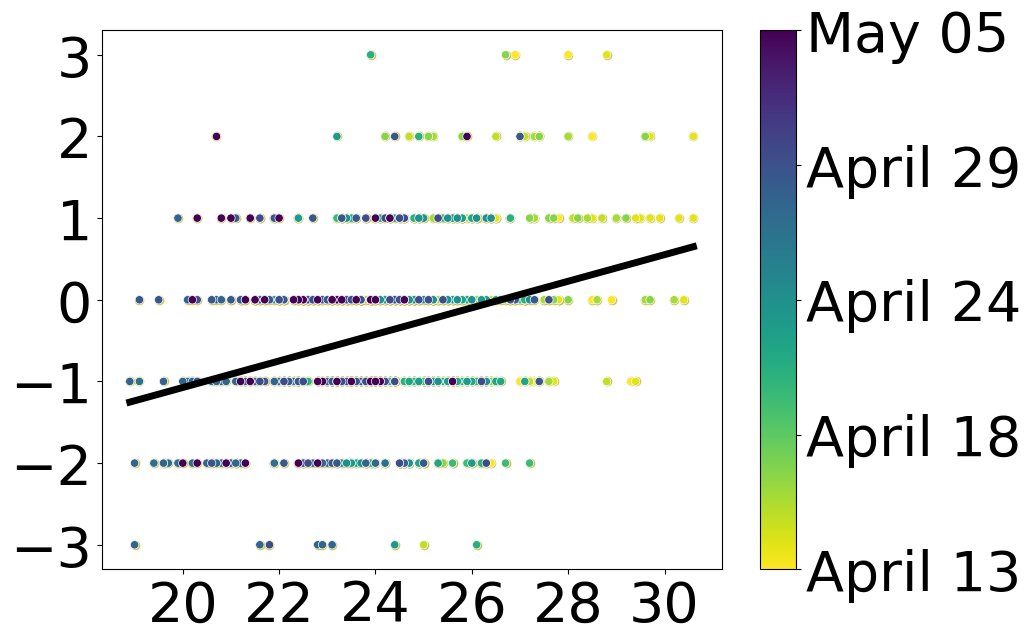

                            OLS Regression Results                            
Dep. Variable:      thermal_sensation   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     73.93
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           6.48e-17
Time:                        19:01:10   Log-Likelihood:                -914.11
No. Observations:                 628   AIC:                             1832.
Df Residuals:                     626   BIC:                             1841.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3274      0.461     -9.382      0.0

In [8]:
lm_result = smf.ols(formula='thermal_sensation ~ set', data=df_data_1bldg).fit()

# Prepare the DataFrame
df_data_1bldg['timestamp'] = pd.to_datetime(df_data_1bldg['timestamp'])
df_data_1bldg[ 'days_since_start'] = (df_data_1bldg['timestamp'] - df_data_1bldg['timestamp'].min()).dt.days

# Plotting
plt.figure(figsize=(10, 7))
sns.regplot(x='set', y='thermal_sensation', data=df_data_1bldg, scatter_kws={'color': '#CCBB44'}, line_kws={'color': 'black', 'linewidth': 5}, ci=None)
sns.scatterplot(x='set', y='thermal_sensation', data=df_data_1bldg, hue='days_since_start', palette='viridis_r')

# Select 5 evenly spaced dates
selected_dates = np.linspace(df_data_1bldg['days_since_start'].min(), df_data_1bldg['days_since_start'].max(), 5, endpoint=True)
selected_date_labels = [(df_data_1bldg['timestamp'].min() + pd.Timedelta(days=int(day))).strftime('%B %d') for day in selected_dates]

# Add colorbar with selected dates
norm = plt.Normalize(df_data_1bldg['days_since_start'].min(), df_data_1bldg['days_since_start'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, aspect=15)
cbar.set_ticks(selected_dates)
cbar.set_ticklabels(selected_date_labels)
cbar.ax.tick_params(labelsize=40)

# modify the x and y axis
plt.xlabel('', fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)
plt.xticks(fontsize=40)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=40)  # Set font size for y-axis tick labels
plt.grid(False)
plt.legend().remove()

# change the font to sen-serif Times new roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('fig/Bldg_neutral_a.pdf', format='pdf', bbox_inches='tight')
plt.show()

# statistical anayalsis summary
print(lm_result.summary())
print("******************************************************************************")

# check whether the correaltion (slope) is significant
if lm_result.pvalues['set'] < 0.05:
    a = lm_result.params['set']
    b = lm_result.params['Intercept']
    temp_n = -b / a
    temp_up = (0.85-b)/a
    temp_low = (-0.85-b)/a
    print('Neutral temperature: {:.1f}'.format(temp_n), chr(176),'C', sep='')
    print('Comfort Zone: {:.1f}'.format(temp_low), chr(176),'C to {:.1f}'.format(temp_up), chr(176),'C', sep='')
else:
    print('The slope is not significant, p value: {:.2f}'.format(lm_result.pvalues['set']))

### Approach (b)

/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_38203/1319815145.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, aspect=15)


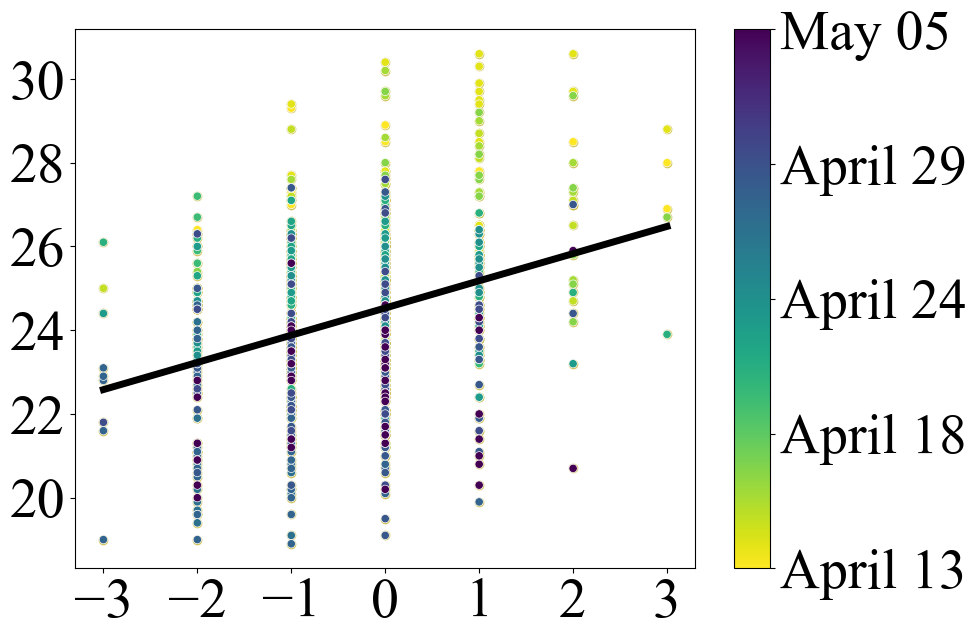

                            OLS Regression Results                            
Dep. Variable:                    set   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     73.93
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           6.48e-17
Time:                        19:01:12   Log-Likelihood:                -1348.8
No. Observations:                 628   AIC:                             2702.
Df Residuals:                     626   BIC:                             2710.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            24.5296      0.08

In [9]:
lm_result = smf.ols(formula='set ~ thermal_sensation', data=df_data_1bldg).fit()

# Plotting
plt.figure(figsize=(10, 7))
sns.regplot(x='thermal_sensation', y='set', data=df_data_1bldg, scatter_kws={'color': '#CCBB44'}, line_kws={'color': 'black', 'linewidth': 5}, ci=None)
sns.scatterplot(x='thermal_sensation', y='set', data=df_data_1bldg, hue='days_since_start', palette='viridis_r')

# Select 5 evenly spaced dates
selected_dates = np.linspace(df_data_1bldg['days_since_start'].min(), df_data_1bldg['days_since_start'].max(), 5, endpoint=True)
selected_date_labels = [(df_data_1bldg['timestamp'].min() + pd.Timedelta(days=int(day))).strftime('%B %d') for day in selected_dates]

# Add colorbar with selected dates
norm = plt.Normalize(df_data_1bldg['days_since_start'].min(), df_data_1bldg['days_since_start'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, aspect=15)
cbar.set_ticks(selected_dates)
cbar.set_ticklabels(selected_date_labels)
cbar.ax.tick_params(labelsize=40)

# modify the x and y axis
plt.xlabel('', fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)
plt.xticks(fontsize=40)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=40)  # Set font size for y-axis tick labels
plt.grid(False)
plt.legend().remove()

# plt.title('Regress thermal sensation votes on indoor temperature')
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('fig/Bldg_neutral_b.pdf', format='pdf', bbox_inches='tight')
plt.show()

# statistical anayalsis summary
print(lm_result.summary())
print("******************************************************************************")

# check whether the correaltion (slope) is significant
if lm_result.pvalues['thermal_sensation'] < 0.05:
    a = lm_result.params['thermal_sensation']
    b = lm_result.params['Intercept']
    temp_n = b
    temp_up = 0.85*a + b
    temp_low = (-0.85)*a + b
    print('Neutral temperature: {:.1f}'.format(temp_n), chr(176),'C', sep='')
    print('Comfort Zone: {:.1f}'.format(temp_low), chr(176),'C to {:.1f}'.format(temp_up), chr(176),'C', sep='')
else:
    print('The slope is not significant, p value: {:.2f}'.format(lm_result.pvalues['set']))

In [10]:
# calculate pearson correlation coefficient
df_data_1bldg[['set', 'thermal_sensation']].corr()

,set,thermal_sensation
set,1.000000,0.324998
thermal_sensation,0.324998,1.000000


### TLS method

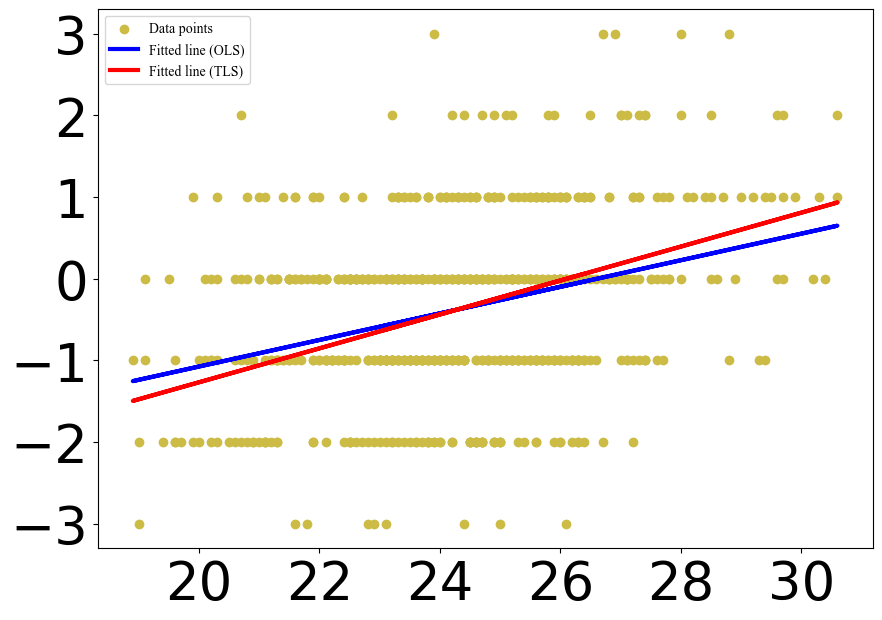

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.odr import ODR, Model, RealData
import statsmodels.formula.api as smf

# Sample data points
x = df_data_1bldg['set'].to_numpy()
y = df_data_1bldg['thermal_sensation'].to_numpy()

# OLS regression
slope_ols, intercept_ols, _, _, _ = stats.linregress(x, y)

# Define the model function for the orthogonal regression
def linear_func(B, x):
    return B[0] * x + B[1]

# Create a RealData object with the data points
data = RealData(x, y)

# Create a Model object with the model function
model = Model(linear_func)

# Create an ODR object with the data, model, and an initial guess for the parameters
odr = ODR(data, model, beta0=[1, 0])

# Run the orthogonal regression
output = odr.run()

# Plot the data points and fitted lines
plt.figure(figsize=(10, 7))
plt.scatter(x, y, color='#CCBB44', label='Data points')
plt.plot(x, slope_ols * x + intercept_ols, color='blue', linewidth=3, label='Fitted line (OLS)')
plt.plot(x, linear_func(output.beta, x), color='red', linewidth=3, label='Fitted line (TLS)')
plt.xlabel('', rotation=0, fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)

# Additional plot settings
plt.rcParams['font.family'] = 'Times New Roman'
plt.xticks(fontsize=38)
plt.yticks(fontsize=38)
plt.grid(False)
plt.legend()

# Show the plot
plt.show()


In [15]:
print('slope', output.beta[0])
print('intercept', output.beta[1])

slope 4.815252252220004
intercept 26.101778377804834


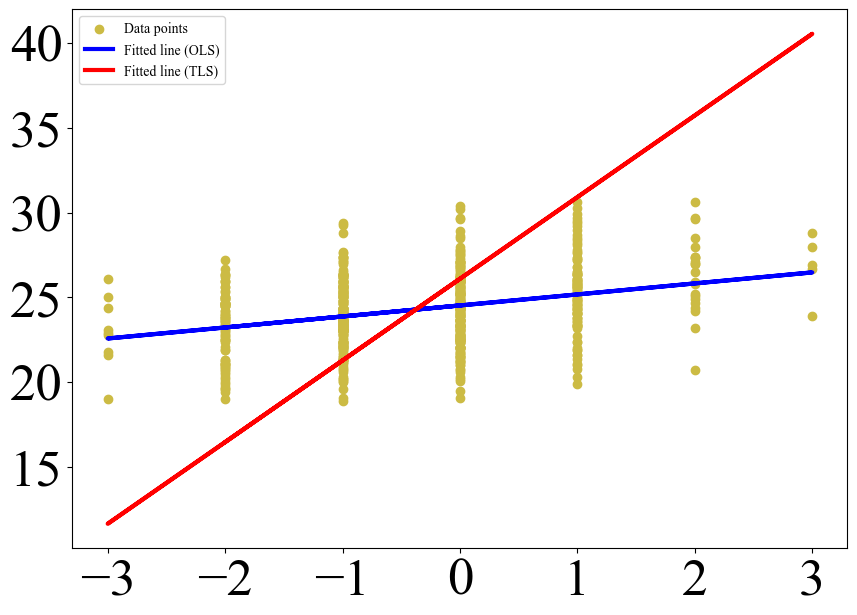

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.odr import ODR, Model, RealData
import statsmodels.formula.api as smf

# Sample data points
y = df_data_1bldg['set'].to_numpy()
x = df_data_1bldg['thermal_sensation'].to_numpy()

# OLS regression
slope_ols, intercept_ols, _, _, _ = stats.linregress(x, y)

# Define the model function for the orthogonal regression
def linear_func(B, x):
    return B[0] * x + B[1]

# Create a RealData object with the data points
data = RealData(x, y)

# Create a Model object with the model function
model = Model(linear_func)

# Create an ODR object with the data, model, and an initial guess for the parameters
odr = ODR(data, model, beta0=[1, 0])

# Run the orthogonal regression
output = odr.run()

# Plot the data points and fitted lines
plt.figure(figsize=(10, 7))
plt.scatter(x, y, color='#CCBB44', label='Data points')
plt.plot(x, slope_ols * x + intercept_ols, color='blue', linewidth=3, label='Fitted line (OLS)')
plt.plot(x, linear_func(output.beta, x), color='red', linewidth=3, label='Fitted line (TLS)')
plt.xlabel('', rotation=0, fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)

# Additional plot settings
plt.rcParams['font.family'] = 'Times New Roman'
plt.xticks(fontsize=38)
plt.yticks(fontsize=38)
plt.grid(False)
plt.legend()

# Show the plot
plt.show()


In [16]:
print('slope', output.beta[0])
print('intercept', output.beta[1])

slope 4.815252252220004
intercept 26.101778377804834


Explore time series plot of TSV, Tin, Tout and Thermal Preferences

In [125]:
# replace 'warmer' with 1 and 'cooler' with -1, and 'no change' with 0 in thermal_preference column
df_data_1bldg.loc[df_data_1bldg.thermal_preference == 'warmer', 'thermal_preference'] = 1
df_data_1bldg.loc[df_data_1bldg.thermal_preference == 'cooler', 'thermal_preference'] = -1
df_data_1bldg.loc[df_data_1bldg.thermal_preference == 'no change', 'thermal_preference'] = 0
df_data_1bldg.thermal_preference.unique()


array([1, 0, -1, nan], dtype=object)

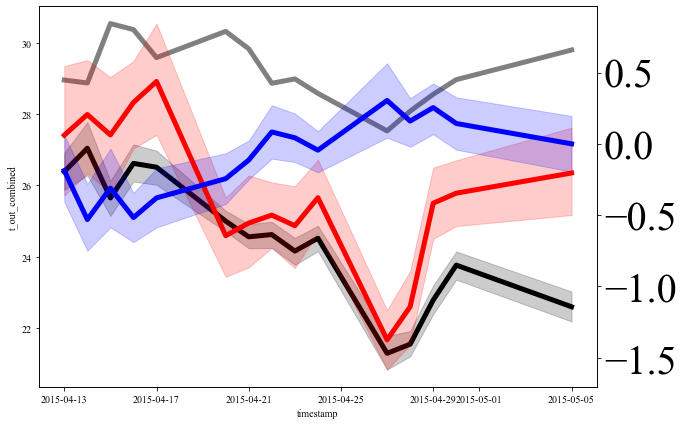

In [128]:
# plot timeseries t_out and set
plt.figure(figsize=(10, 7))
sns.lineplot(x='timestamp', y='t_out_combined', data=df_data_1bldg, color='grey', linewidth=5)
sns.lineplot(x='timestamp', y='set', data=df_data_1bldg, color='black', linewidth=5)
# plot TSV on the right axis
ax2 = plt.twinx()
sns.lineplot(x='timestamp', y='thermal_sensation', data=df_data_1bldg, color='red', linewidth=5, ax=ax2)
# plot thermal preference on the right axis
sns.lineplot(x='timestamp', y='thermal_preference', data=df_data_1bldg, color='blue', linewidth=5, ax=ax2)

# modify the x and y axis
plt.xlabel('', fontsize=40)
plt.ylabel('', rotation=0, fontsize=40)
plt.xticks(fontsize=40)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=40)  # Set font size for y-axis tick labels
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('fig/Bldg_neutral_c.pdf', format='pdf', bbox_inches='tight')
plt.show()



### Calculate PMV Zone

In [141]:
# calculate mean values
print('mean vel: {:.2f}'.format(df_data_1bldg.vel.mean()))
print('mean rh: {:.2f}'.format(df_data_1bldg.rh.mean()))
print('mean met: {:.2f}'.format(df_data_1bldg.met.mean()))
print('mean clo: {:.2f}'.format(df_data_1bldg.clo.mean()))


mean vel: 0.17
mean rh: 55.57
mean met: 1.20
mean clo: 0.58


## Analysis on All buildings

### Define functions for the two regression appraoches

In [11]:
# regress TSV against SET
def approach_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ set', data=bldg).fit()
        slope = lm_result.params['set']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['set'] < 0.05:
            a = slope
            b = intercept
            temp_n = -b / a
            temp_up = (0.85-b)/a
            temp_low = (-0.85-b)/a
            return [slope, intercept, temp_n, temp_up, temp_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

# regress SET against TSV  
def approach_b(bldg):
    try:
        lm_result = smf.ols(formula='set ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['thermal_sensation'] < 0.05:
            a = slope
            b = intercept
            temp_n = b
            temp_up = 0.85*a + b
            temp_low = (-0.85)*a + b
            return [slope, intercept, temp_n, temp_up, temp_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

for operative temperature

In [8]:
# regress TSV against top
def approach_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ top', data=bldg).fit()
        slope = lm_result.params['top']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['top'] < 0.05:
            a = slope
            b = intercept
            temp_n = -b / a
            temp_up = (0.85-b)/a
            temp_low = (-0.85-b)/a
            return [slope, intercept, temp_n, temp_up, temp_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

# regress top against TSV  
def approach_b(bldg):
    try:
        lm_result = smf.ols(formula='top ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['thermal_sensation'] < 0.05:
            a = slope
            b = intercept
            temp_n = b
            temp_up = 0.85*a + b
            temp_low = (-0.85)*a + b
            return [slope, intercept, temp_n, temp_up, temp_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

### Calculate mean values for each building

In [16]:
# Define the columns for which you want to calculate the mean
mean_cols = ['set', 'top', 't_out_combined']

# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data.groupby('building_id')[mean_cols].mean()

# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)

# Merge df_means with the metadata
df_bldg = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type']], on='building_id', how='left')

# Reset the building cooling type as string
df_bldg['cooling_type'] = df_bldg['cooling_type'].str.title()

### Calcualte neutral temperature for each building

In [17]:
# store regression results as columns
columns_name = ['slope', 'intercept', 'temp_n', 'temp_up', 'temp_low']

# calculate regression results for each building
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: approach_a(x)[i] if approach_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: approach_b(x)[i] if approach_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

df_bldg.head()

,building_id,set,top,t_out_combined,records,cooling_type,building_type,slope_a,slope_b,intercept_a,intercept_b,temp_n_a,temp_n_b,temp_up_a,temp_up_b,temp_low_a,temp_low_b
0,1,25.454225,23.360524,15.560695,170,Mixed Mode,office,0.282810,0.708579,-5.944612,22.891465,21.019827,22.891465,24.025381,23.493757,18.014273,22.289173
1,2,23.616000,22.328590,13.995833,83,Air Conditioned,office,0.643948,0.292102,-14.358447,22.322748,22.297532,22.322748,23.617515,22.571035,20.977549,22.074462
2,3,23.694118,23.178237,0.583480,85,Air Conditioned,office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,24.164706,23.936241,19.225391,137,Mixed Mode,office,0.478756,0.462422,-11.383983,23.901268,23.778269,23.901268,25.553704,24.294327,22.002833,23.508209
4,5,22.271875,22.095310,9.048210,128,Air Conditioned,office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filter out non-signficant regression results

In [18]:
# number of all buildings
print('Total buildings:', len(df_bldg))
print("Total NV buildings:", len(df_bldg[df_bldg['cooling_type'] == 'Naturally Ventilated']))
print("Total AC buildings:", len(df_bldg[df_bldg['cooling_type'] == 'Air Conditioned']))

# get rid of all nan values in the temp_n_a column
df_bldg_sig_a = df_bldg[~df_bldg['temp_n_a'].isna()]
df_bldg_NV_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Naturally Ventilated']
df_bldg_AC_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Air Conditioned']
df_office_AC_a = df_bldg_AC_a[df_bldg_AC_a['building_type'] == 'office'].copy()
df_office_NV_a = df_bldg_NV_a[df_bldg_NV_a['building_type'] == 'office'].copy()

print("******************************************************************************")
print('Approach (a)')
print('Total signficant buildings:', len(df_bldg_sig_a))
print('Total signficant NV buildings:', len(df_bldg_NV_a))
print('Total signficant NV office buildings:', len(df_office_NV_a))
print('Total signficant AC buildings:', len(df_bldg_AC_a))
print('Total signficant AC office buildings:', len(df_office_AC_a))


# get rid of all nan values in the temp_n_a column
df_bldg_sig_b = df_bldg[~df_bldg['temp_n_b'].isna()]
df_bldg_NV_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Naturally Ventilated']
df_bldg_AC_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Air Conditioned']
df_office_AC_b = df_bldg_AC_b[df_bldg_AC_b['building_type'] == 'office'].copy()
df_office_NV_b = df_bldg_NV_b[df_bldg_NV_b['building_type'] == 'office'].copy()

print("******************************************************************************")
print('Approach (b)')
print('Total signficant buildings:', len(df_bldg_sig_b))
print('Total signficant NV buildings:', len(df_bldg_NV_b))
print('Total signficant NV office buildings:', len(df_office_NV_b))
print('Total signficant AC buildings:', len(df_bldg_AC_b))
print('Total signficant AC office buildings:', len(df_office_AC_b))

Total buildings: 518
Total NV buildings: 197
Total AC buildings: 153
******************************************************************************
Approach (a)
Total signficant buildings: 184
Total signficant NV buildings: 61
Total signficant NV office buildings: 41
Total signficant AC buildings: 74
Total signficant AC office buildings: 74
******************************************************************************
Approach (b)
Total signficant buildings: 198
Total signficant NV buildings: 67
Total signficant NV office buildings: 41
Total signficant AC buildings: 74
Total signficant AC office buildings: 74


## Define ACM model function: weighted linear regression

In [19]:
# Weighted regression function
def weighted_regression(x, y, weights):
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()
    intercept, slope = model.params
    print('p value {:.3f}'.format(model.pvalues[1]))
    print(model.summary())
    return intercept, slope

## Adaptive Comfort Model (ACM) for all NV offices

In [20]:
# only keep buildings with 10 < t_out_combined < 35
df_ACM_NV_a = df_office_NV_a[(df_office_NV_a['t_out_combined'] >= 10) & (df_office_NV_a['t_out_combined'] <= 35)]
df_ACM_NV_b = df_office_NV_b[(df_office_NV_b['t_out_combined'] >= 10) & (df_office_NV_b['t_out_combined'] <= 35)]
print("Total buildings for Approach (a) ACM_NV:", len(df_ACM_NV_a))
print("Total buildings for Approach (b) ACM_NV:", len(df_ACM_NV_b))

Total buildings for Approach (a) ACM_NV: 39
Total buildings for Approach (b) ACM_NV: 39


### Approach (a)

In [21]:
# conduct weighted ACM regression line and print out the results
temp_n_a_intercept, temp_n_a_slope = weighted_regression(df_ACM_NV_a['t_out_combined'], df_ACM_NV_a['temp_n_a'], df_ACM_NV_a['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(temp_n_a_slope))
print('ACM regression line slope: {:.2f}'.format(temp_n_a_intercept))

# calculate the mean comfort zone
range_a = df_ACM_NV_a['temp_up_a'].mean() - df_ACM_NV_a['temp_low_a'].mean()
print('ACM comfort zone: {:.2f}'.format(range_a))


p value 0.000
                            WLS Regression Results                            
Dep. Variable:               temp_n_a   R-squared:                       0.407
Model:                            WLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     25.35
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           1.27e-05
Time:                        20:03:27   Log-Likelihood:                -83.089
No. Observations:                  39   AIC:                             170.2
Df Residuals:                      37   BIC:                             173.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.3442     

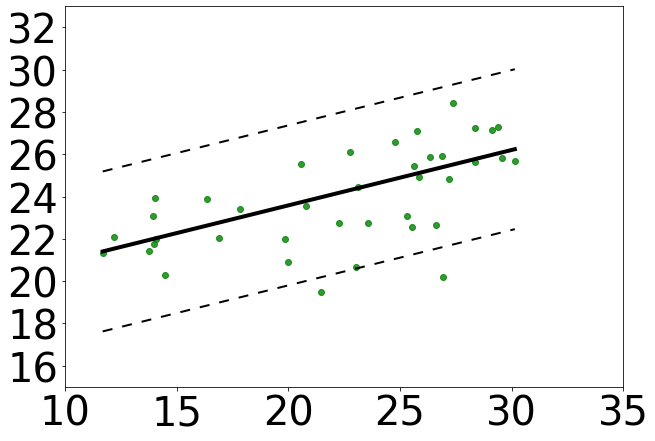

In [22]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_NV_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept + range_a/2
low_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept - range_a/2
middle_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_a', data=df_ACM_NV_a, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(15, 33)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('fig/ACM_NV_neutral_a.pdf', format='pdf', bbox_inches='tight')


check if the result is different when y is operative temperature

### Approach (b)

In [38]:
# conduct weighted ACM_NV regression line and print out the results
temp_n_b_intercept, temp_n_b_slope = weighted_regression(df_ACM_NV_b['t_out_combined'], df_ACM_NV_b['temp_n_b'], df_ACM_NV_b['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM_NV regression line slope: {:.2f}'.format(temp_n_b_slope))
print('ACM_NV regression line slope: {:.2f}'.format(temp_n_b_intercept))

# calculate the mean comfort zone
range_b = df_ACM_NV_b['temp_up_b'].mean() - df_ACM_NV_b['temp_low_b'].mean()
print('ACM_NV comfort zone: {:.2f}'.format(range_b))

p value 0.000
                            WLS Regression Results                            
Dep. Variable:               temp_n_b   R-squared:                       0.692
Model:                            WLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     73.98
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           6.11e-10
Time:                        19:21:05   Log-Likelihood:                -66.342
No. Observations:                  35   AIC:                             136.7
Df Residuals:                      33   BIC:                             139.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.4439     

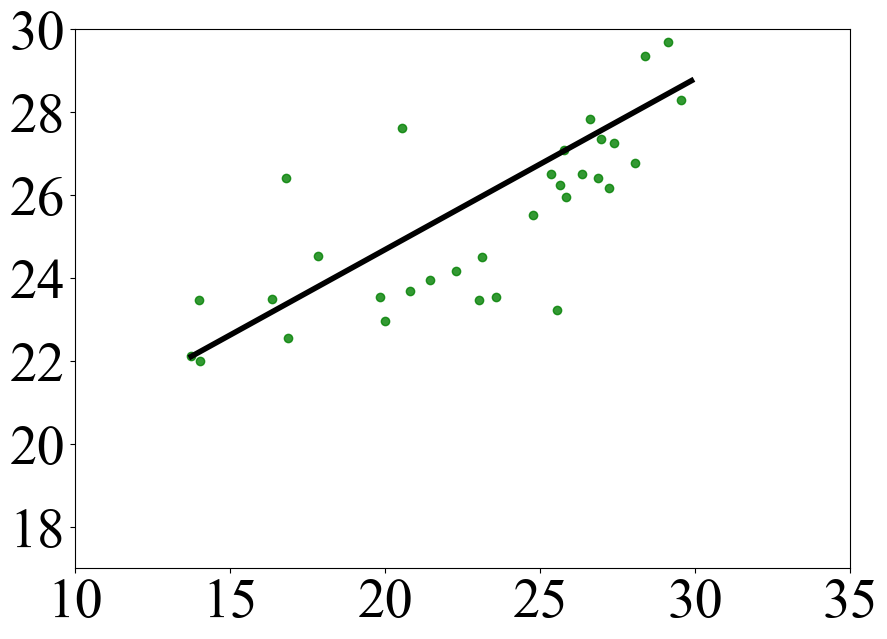

In [39]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_NV_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept + range_b/2
low_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept - range_b/2
middle_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_b', data=df_ACM_NV_b, fit_reg=False, scatter_kws={'color': 'green'})
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 30)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('fig/ACM_NV_neutral_b.pdf', format='pdf', bbox_inches='tight')

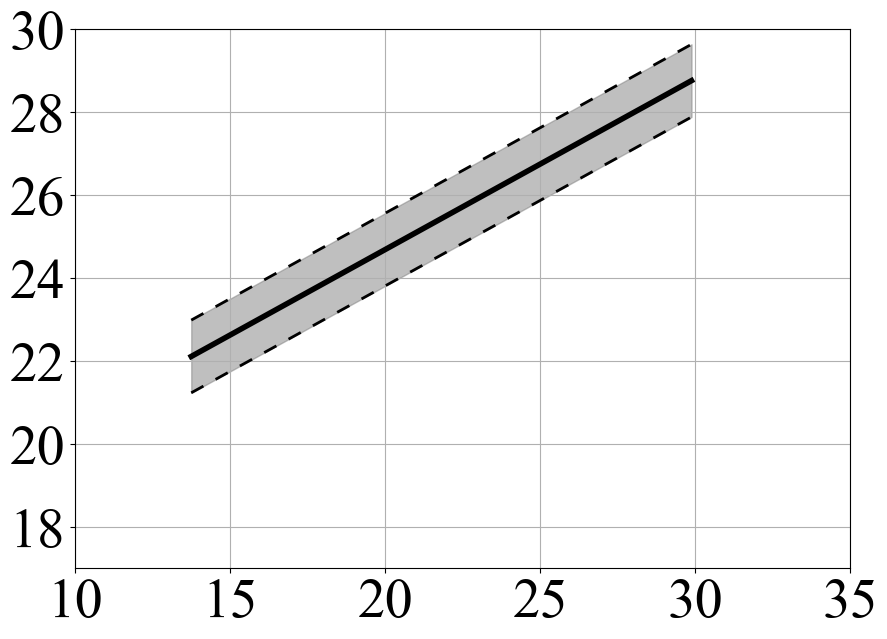

In [40]:
# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
plt.fill_between(t_out_combined, up_line, low_line, color='grey', alpha=0.5)
plt.xlabel('', fontsize=40)
plt.ylabel('', rotation=90, fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 30)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('fig/ACM_NV_comfort_b.pdf', format='pdf', bbox_inches='tight')


## Adaptive Comfort Model (ACM) for all AC offices

In [32]:
# only keep buildings with 10 < t_out_combined < 35
df_ACM_AC_a = df_office_AC_a[(df_office_AC_a['t_out_combined'] >= 10) & (df_office_AC_a['t_out_combined'] <= 35)]
df_ACM_AC_b = df_office_AC_b[(df_office_AC_b['t_out_combined'] >= 10) & (df_office_AC_b['t_out_combined'] <= 35)]
print("Total buildings for Approach (a) ACM_AC:", len(df_ACM_AC_a))
print("Total buildings for Approach (b) ACM_AC:", len(df_ACM_AC_b))

Total buildings for Approach (a) ACM_AC: 36
Total buildings for Approach (b) ACM_AC: 36


### Approach (a)

In [33]:
# conduct weighted ACM regression line and print out the results
temp_n_a_intercept, temp_n_a_slope = weighted_regression(df_ACM_AC_a['t_out_combined'], df_ACM_AC_a['temp_n_a'], df_ACM_AC_a['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(temp_n_a_slope))
print('ACM regression line slope: {:.2f}'.format(temp_n_a_intercept))

# calculate the mean comfort zone
range_a = df_ACM_AC_a['temp_up_a'].mean() - df_ACM_AC_a['temp_low_a'].mean()
print('ACM comfort zone: {:.2f}'.format(range_a))


p value 0.002
                            WLS Regression Results                            
Dep. Variable:               temp_n_a   R-squared:                       0.241
Model:                            WLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     10.81
Date:                Thu, 04 Jan 2024   Prob (F-statistic):            0.00235
Time:                        19:19:22   Log-Likelihood:                -80.471
No. Observations:                  36   AIC:                             164.9
Df Residuals:                      34   BIC:                             168.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             19.2402     

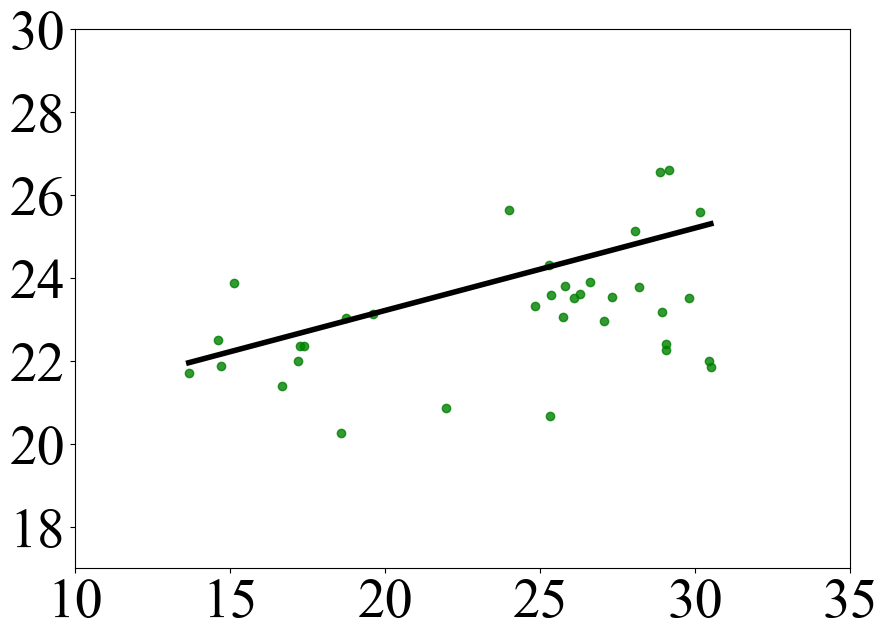

In [34]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_AC_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept + range_a/2
low_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept - range_a/2
middle_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_a', data=df_ACM_AC_a, fit_reg=False, scatter_kws={'color': 'green'})
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 30)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('fig/ACM_AC_neutral_a.pdf', format='pdf', bbox_inches='tight')


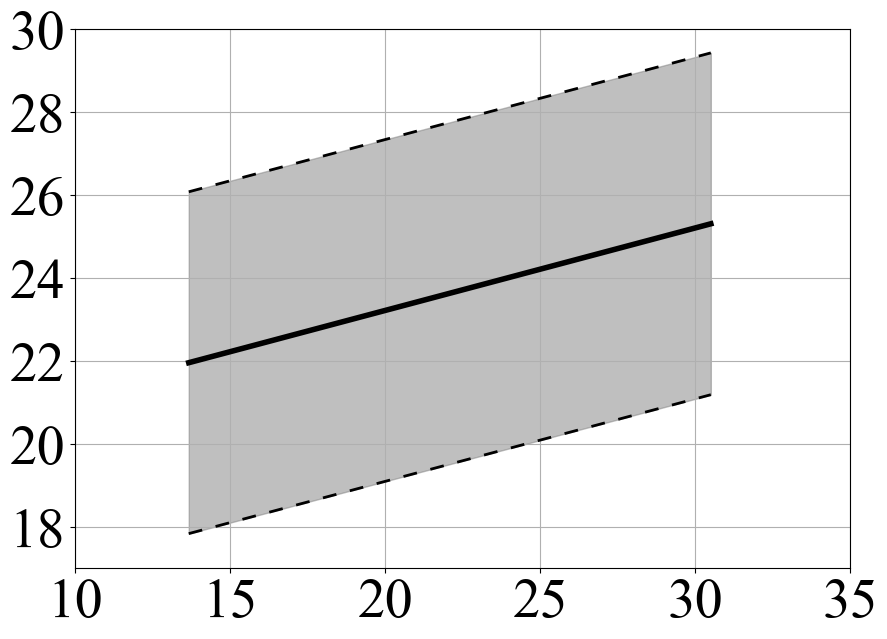

In [35]:
# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
plt.fill_between(t_out_combined, up_line, low_line, color='grey', alpha=0.5)
plt.xlabel('', fontsize=40)
plt.ylabel('', rotation=90, fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 30)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('fig/ACM_AC_comfort_a.pdf', format='pdf', bbox_inches='tight')

### Approach (b)

In [36]:
# conduct weighted ACM_AC regression line and print out the results
temp_n_b_intercept, temp_n_b_slope = weighted_regression(df_ACM_AC_b['t_out_combined'], df_ACM_AC_b['temp_n_b'], df_ACM_AC_b['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM_AC regression line slope: {:.2f}'.format(temp_n_b_slope))
print('ACM_AC regression line slope: {:.2f}'.format(temp_n_b_intercept))

# calculate the mean comfort zone
range_b = df_ACM_AC_b['temp_up_b'].mean() - df_ACM_AC_b['temp_low_b'].mean()
print('ACM_AC comfort zone: {:.2f}'.format(range_b))

p value 0.622
                            WLS Regression Results                            
Dep. Variable:               temp_n_b   R-squared:                       0.007
Model:                            WLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.2478
Date:                Thu, 04 Jan 2024   Prob (F-statistic):              0.622
Time:                        19:20:14   Log-Likelihood:                -53.420
No. Observations:                  36   AIC:                             110.8
Df Residuals:                      34   BIC:                             114.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             23.4010     

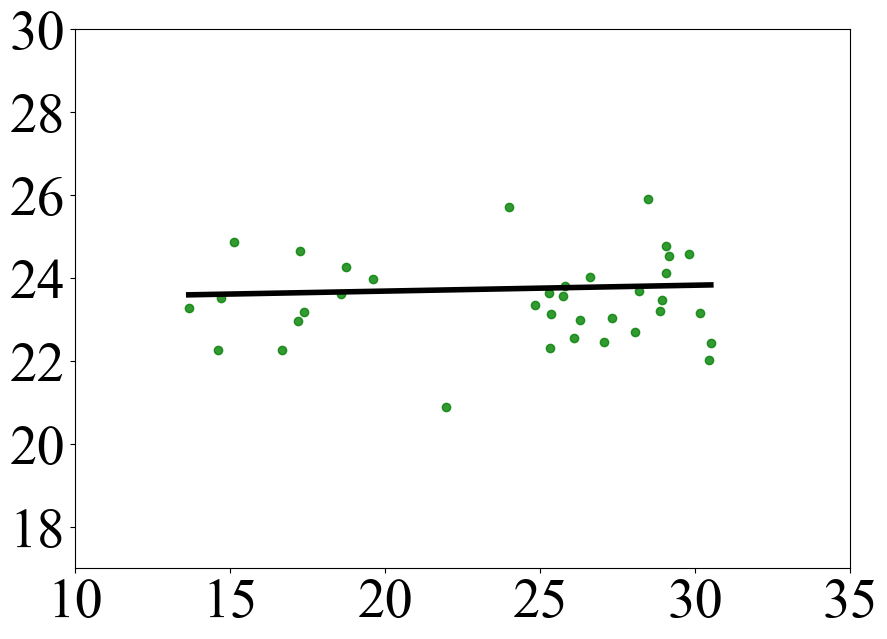

In [37]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_AC_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept + range_b/2
low_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept - range_b/2
middle_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_b', data=df_ACM_AC_b, fit_reg=False, scatter_kws={'color': 'green'})
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 30)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('fig/ACM_AC_neutral_b.pdf', format='pdf', bbox_inches='tight')

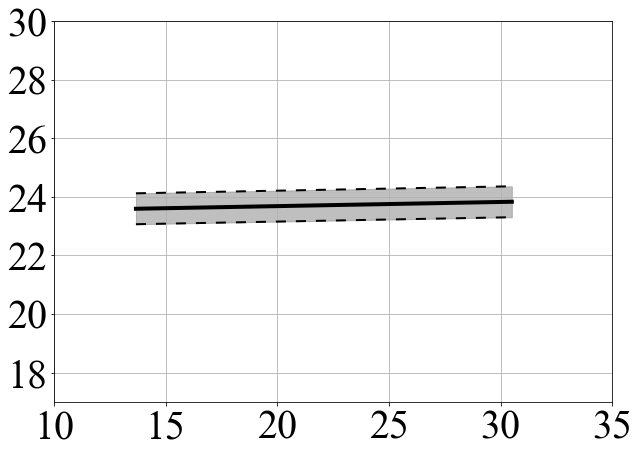

In [180]:
# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
plt.fill_between(t_out_combined, up_line, low_line, color='grey', alpha=0.5)
plt.xlabel('', fontsize=40)
plt.ylabel('', rotation=90, fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 30)
plt.grid(True)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('fig/ACM_comfort_b.pdf', format='pdf', bbox_inches='tight')



### MSE

In [159]:
# calculate mean squared error (MSE) for the regression line
def mse(x, y, intercept, slope):
    y_pred = slope*x + intercept
    mse = np.mean((y-y_pred)**2)
    return mse

print('Approach (a): {:.2f}'.format(mse(df_ACM_a['t_out_combined'], df_ACM_a['temp_n_a'], temp_n_a_intercept, temp_n_a_slope)))
print('Approach (b): {:.2f}'.format(mse(df_ACM_b['t_out_combined'], df_ACM_b['temp_n_b'], temp_n_b_intercept, temp_n_b_slope)))

Approach (a): 5.08
Approach (b): 1.13
